## Chapter 3 from Bjornstad (2018): $R_0$

Let us explore using weekly measles-data from the 2003 outbreak in Niamey, Niger . The data is available as `niamey` in the `epimdr`-package. The `tot_cases`-column represents the total incidence across the city for each week of the outbreak.

In [1]:
library(epimdr)

Loading required package: shiny
Loading required package: deSolve
Loading required package: phaseR
Loading required package: polspline


In [2]:
data(niamey)
head(niamey[, 1:5])

absweek,week,tot_cases,tot_mort,lethality
1,45,11,0,0.000000
2,46,12,1,8.333333
3,47,15,0,0.000000
4,48,14,1,7.142857
5,49,30,0,0.000000
6,50,41,1,2.439024


We can do a visual inspection to identify the initial period of exponential growth:

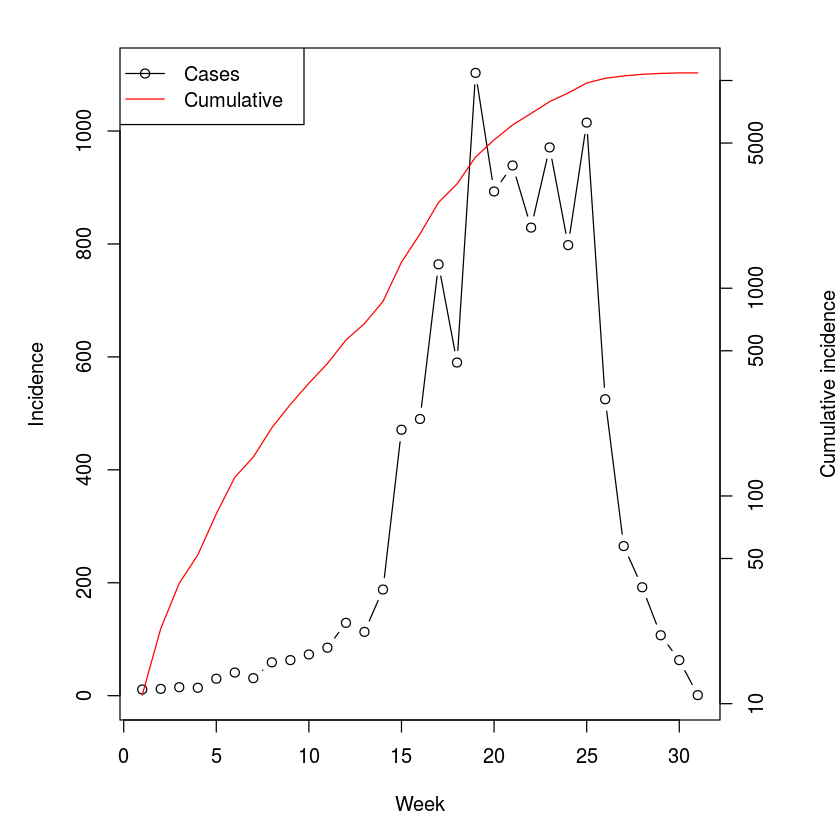

In [3]:
par(mar = c(5,5,2,5))
plot(niamey$absweek, niamey$tot_cases, type = "b", 
     xlab = "Week", ylab = "Incidence")
par(new = TRUE)
plot(niamey$absweek, niamey$cum_cases, type = "l", 
     col = "red", axes = FALSE, xlab = NA, ylab = NA, log = "y")
axis(side = 4)
mtext(side = 4, line = 4, "Cumulative incidence")
legend("topleft", legend = c("Cases", "Cumulative"),
       lty = c(1,1), pch = c(1,NA), col = c("black", "red"))

The cumulative incidence looks pretty log-linear for the first 6 weeks or so (Fig. \[fig:niameyweekly\]). The data is weekly and the serial interval for measles is around 10-12 days, thus V is around 1.5-1.8 weeks; We calculate $R_0$ assuming either $1.5$ or $1.8$:

In [4]:
fit=lm(log(cum_cases)~absweek, subset=absweek<7, 
     data=niamey)
r=fit$coef["absweek"]
V=c(1.5, 1.8)
V*r+1

[1] 1.694233 1.833080

So a fast-and-furious estimate of the reproductive ratio for this outbreak places it in the 1.5-2 range. Measles exhibits recurrent epidemics in the presence of various vaccination campaigns in Niger, so this number represents an estimate of the *effective* reproductive ratio, $R_E$, at the beginning of this epidemic.

In their analysis of the SARS epidemics, showed that for an infection with distinct latent and infectious periods a more refined estimate is given by $R = V r + 1 + f (1-f) (V r)^2$, where f is the ratio of infectious period to serial interval. For measles the infectious period is around 5 days:

In [5]:
V = c(1.5, 1.8)
f = (5/7)/V
V * r + 1 + f * (1 - f) * (V * r)^2

[1] 1.814450 1.999198

### Maximum likelihood: the chain-binomial model

We employ a standard recipe, for doing a ‘non-standard’ maximum likelihood analysis . The first step is to write a function for the likelihood. Conditional on some parameters, the function returns the negative log-likelihood of observing the data given the model. The likelihood, which is the probability of observing data given a model and some parameter values, is the working-horse of a large part of statistics. R has inbuilt `dxxxx`-functions to calculate the likelihood for any conceivable probability distribution. The function to calculate a binomial likelihood is `dbinom`. We can thus define a likelihood-function for the chain-binomial model [7]:

In [6]:
llik.cb = function(S0, beta, I) {
    n = length(I)
    S = floor(S0 - cumsum(I[-n]))
    p = 1 - exp(-beta * (I[-n])/S0)
    L = -sum(dbinom(I[-1], S, p, log = TRUE))
    return(L)
}

For the the real statistical analysis (below), the two parameters will be estimated simultaneously. However, in order to ease into the idea of likelihood estimation we will consider the two sequentially and visualize the likelihood by plotting it over a grid of potential values. We illustrate with the data on measles from one of the three different reporting centers in Niamey, Niger from 2003 . We first need to aggregate the data into 2-week intervals which is roughly the serial interval for measles. The epidemic in district 1 lasted for 30 weeks (the 31st week is a zero)[8]:

In [7]:
twoweek = rep(1:15, each = 2)
y = sapply(split(niamey$cases_1[1:30], twoweek), sum)
sum(y)

[1] 5920

In district 1 there were 5920 cases during the epidemics, so $S_0$ needs to be at least that number. In the above parameterization $R_E \simeq \beta$, lets initially assume a candidate value of 6500 for $S_0$ and calculate the likelihood for each candidate value of $\beta$ between 1 and 10 by 0.1 (fig. \[fig:profbeta\]):

[1] 2.3

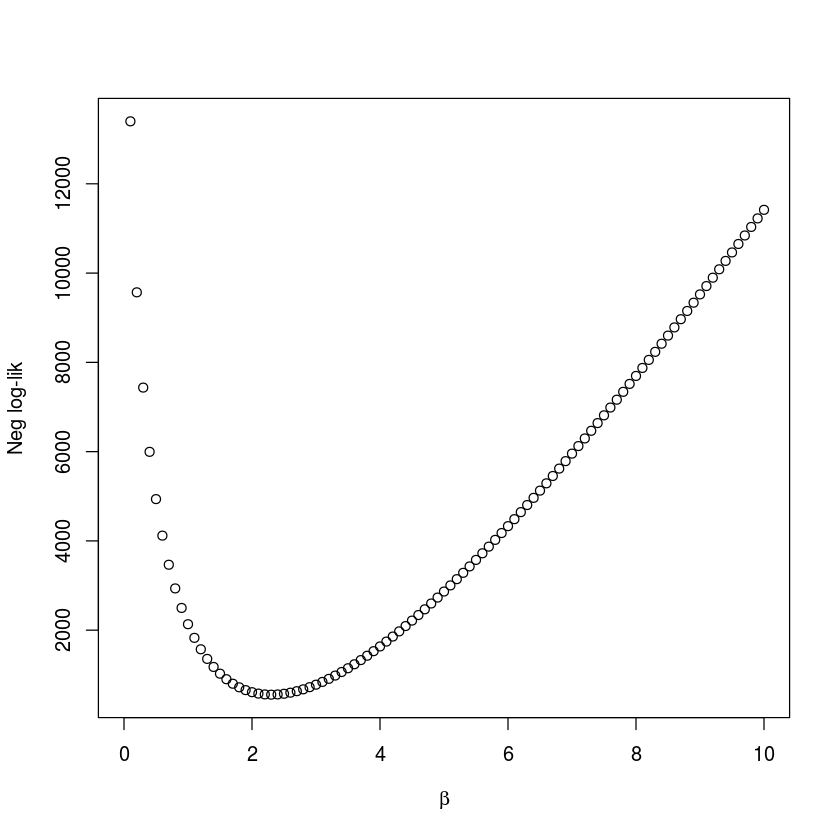

In [8]:
S0cand = 6500       
betacand = seq(0,10, by = .1)
ll = rep(NA, length(betacand))
for(i in 1:length(betacand)){
     ll[i] = llik.cb(S0 = S0cand, beta = betacand[i],
     I = y)}
plot(ll ~ betacand, ylab = "Neg log-lik", 
     xlab = expression(beta)) 
betacand[which.min(ll)]

We follow the convention of using the negative log-likelihood in the profile. Intuitively, one may think that it would be more natural to consider the *likelihood* itself (the probability of observing the data, given particular parameter values). However, since this would be a product of small numbers (one for each observation), computers are not precise enough to distinguish the joint probability from zero if the data set is large. If our $S_0$ guess is right then $\beta$ should be around 2.3. We can do a similar check for $S_0$ (assuming $\beta$ is 2.3). The grid-value associated with the highest likelihood value is 7084.8 (fig. \[fig:profRE\]), so our original $S_0$ guess was good but not perfect.

[1] 7084.8

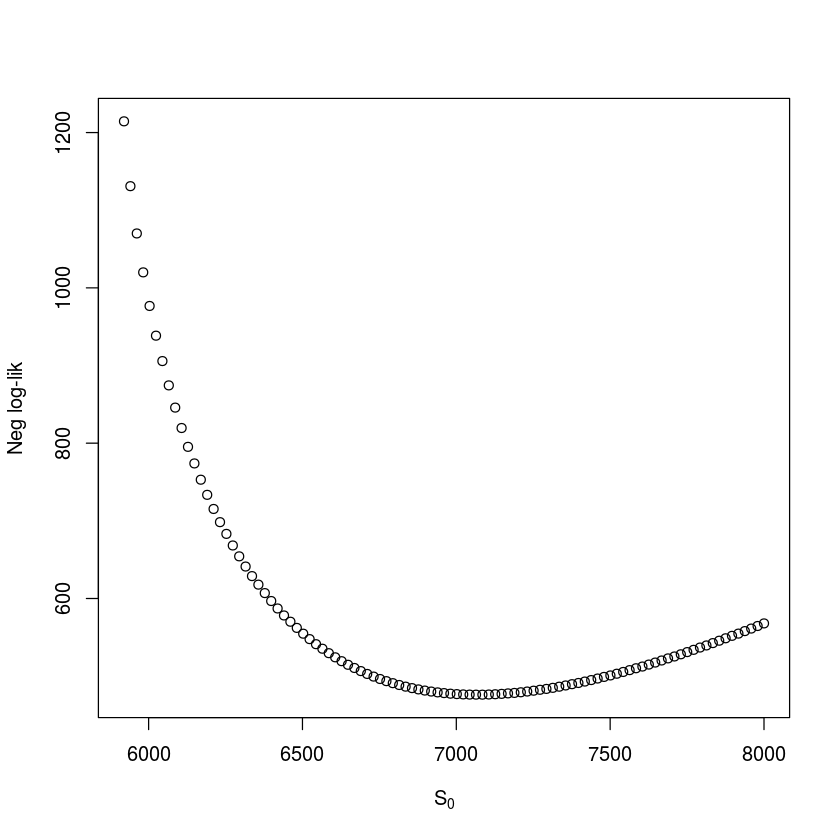

In [9]:
betacand = 2.3
S0cand = seq(5920,8000, length = 101)
ll = rep(NA, length = 101)
for(i in 1:101){
     ll[i] = llik.cb(S0 = S0cand[i], beta = betacand, 
     I = y)}
plot(ll ~ S0cand, ylab = "Neg log-lik", 
     xlab = expression(S[0]))
S0cand[which.min(ll)]

For a proper analysis we minimize the negative log-likelihood by varying both parameters simultaneously. We can do this using the generic `optim`-function or the `mle2`-function in the `bbmle`-package. The `mle2`-function uses `optim` to find maximum likelihood estimates, but also provides confidence intervals, profile likelihoods and a variety of other useful measures . We summarize the basic pertinent likelihood theory for these other measures in section \[sec:c7lik\].

In [10]:
library(bbmle)
fit = mle2(llik.cb, start = list(S0 = 7085, beta = 2.3), 
    method = "Nelder-Mead",data = list(I = y))
summary(fit)
confint(fit)

Loading required package: stats4
Warning message in dbinom(I[-1], S, p, log = TRUE):
“NaNs produced”Warning message in dbinom(I[-1], S, p, log = TRUE):
“NaNs produced”Warning message in dbinom(I[-1], S, p, log = TRUE):
“NaNs produced”Warning message in dbinom(I[-1], S, p, log = TRUE):
“NaNs produced”Warning message in dbinom(I[-1], S, p, log = TRUE):
“NaNs produced”Warning message in dbinom(I[-1], S, p, log = TRUE):
“NaNs produced”Warning message in dbinom(I[-1], S, p, log = TRUE):
“NaNs produced”Warning message in dbinom(I[-1], S, p, log = TRUE):
“NaNs produced”Warning message in dbinom(I[-1], S, p, log = TRUE):
“NaNs produced”

Maximum likelihood estimation

Call:
mle2(minuslogl = llik.cb, start = list(S0 = 7085, beta = 2.3), 
    method = "Nelder-Mead", data = list(I = y))

Coefficients:
       Estimate Std. Error z value     Pr(z)    
S0   7.8158e+03 1.3022e+02  60.019 < 2.2e-16 ***
beta 1.8931e+00 3.6968e-02  51.209 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

-2 log L: 841.831 

Warning message in optim(par = c(beta = 1.89311094280269), fn = function (p) :
“one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly”Warning message in optim(par = c(beta = 1.89311094280269), fn = function (p) :
“one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly”Warning message in optim(par = c(beta = 1.89311094280269), fn = function (p) :
“one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly”Warning message in optim(par = c(beta = 1.89311094280269), fn = function (p) :
“one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly”Warning message in optim(par = c(beta = 1.89311094280269), fn = function (p) :
“one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly”Warning message in optim(par = c(beta = 1.89311094280269), fn = function (p) :
“one-dimensional optimization by Nelder-Mead is unr

,2.5 %,97.5 %
S0,7577.967212,8088.641095
beta,1.820943,1.966336


So the joint MLE estimates are $S_0 = 7816$ (CI: <span>7578, 8088</span>) and $\beta = 1.89$ (CI: {1.82, 1.97}).

Applying statistical tools to biological models – like the chain-binomial – can usefully highlight uncertainties due to parametric interdependencies. In the case of a ‘simple epidemic’ like the measles outbreak considered here, for example, it is conceivable that similar epidemic trajectories can arise from having a large number of initial susceptibles and a low transmission rate, or a more moderate number of susceptibles and a higher transmission rate. We can quantify this through considering the correlation matrix among the parameters of our likelihood analysis; `vcov` calculates their variance-covariance matrix from which we can calculate standard errors according to `sqrt(diag(vcov(fit)))` and `cov2cor` converts this to a correlation matrix. As intuition suggested there is a strong negative correlation between the estimates of the $\beta$ and $S_0$ parameters.

In [11]:
cov2cor(vcov(fit))

,S0,beta
S0,1.0000000,-0.7444261
beta,-0.7444261,1.0000000


## Stochastic simulation

The chain-binomial is both a statistical model for estimation and a stochastic model for dynamics. We can thus write a function to simulate dynamics using the estimated parameters.

In [12]:
sim.cb=function(S0, beta, I0){
   I=I0
   S=S0
   i=1
   while(!any(I==0)){
        i=i+1
        I[i]=rbinom(1, size=S[i-1], prob=1-
           exp(-beta*I[i-1]/S0))
        S[i]=S[i-1]-I[i]
   }
   out=data.frame(S=S, I=I)
   return(out)
}

We superimpose 100 stochastic simulations on the observed epidemic. The simulations from the chain-binomial model brackets the observed epidemic nicely (fig. \[fig:cbsim\]), suggesting that the model is a reasonable first approximation to the underlying dynamics. We will revisit on this case study in the context of outbreak-response vaccination in section \[sec:orv\].

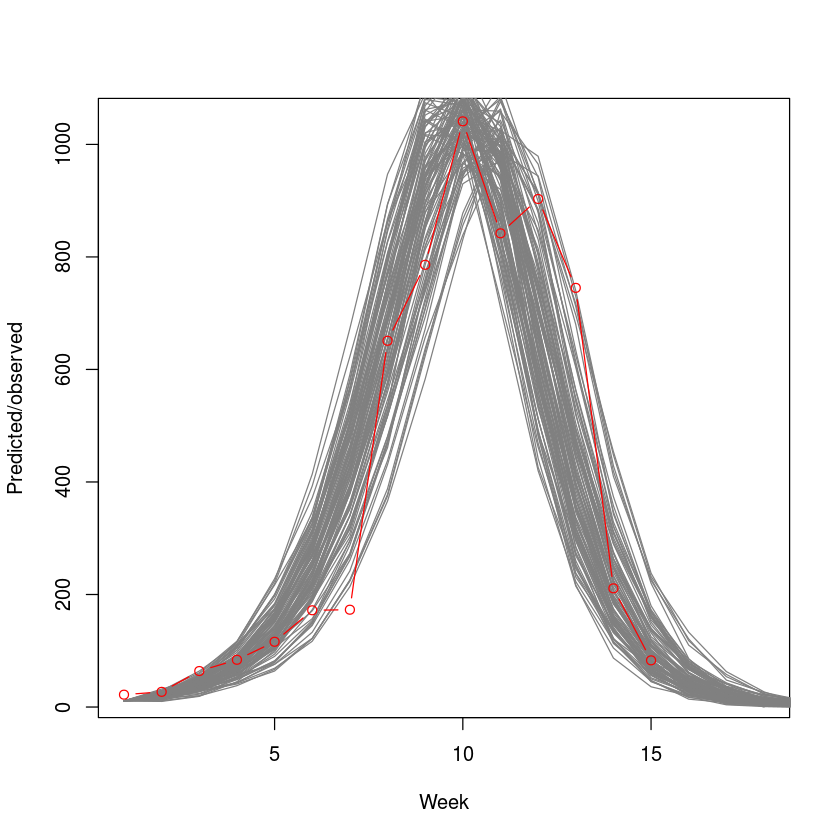

In [13]:
plot(y, type="n", xlim=c(1,18), 
   ylab="Predicted/observed", xlab="Week")
for(i in 1:100){
     sim=sim.cb(S0=floor(coef(fit)["S0"]), 
     beta=coef(fit)["beta"], I0=11)
     lines(sim$I, col=grey(.5))
}
points(y, type="b", col=2)

Further examples
----------------

### Influenza A/H1N1 1977

The `flu` dataset in the `epimdr`-package represents the number of children confined to bed each day during a 1978 outbreak of the reemerging influenza A/H1N1 strain in a boarding school in North England (fig. \[fig:flu\]). This subtype of influenza had been absent from human circulation after the A/H2N2 pandemic of 1957 but reemerge (presumably from some laboratory freezer) in 1977. The school had 763 boys of which 512 boys were confined to bed sometime during the outbreak. None of the boys would have had previous exposure to A/H1N1.

The typical time of illness was 5-7 days. Since the data is number confined to bed each day, the data is not incidence but (a proxy for) *prevalence*. The data looks pretty log-linear for the first 5 days. Family studies have been used to estimate the serial interval for flu between 2 and 4 days . Volunteer studies shows the mean infectious period around 5 days .

,day,cases
9,9,192
10,10,126
11,11,70
12,12,28
13,13,12
14,14,5


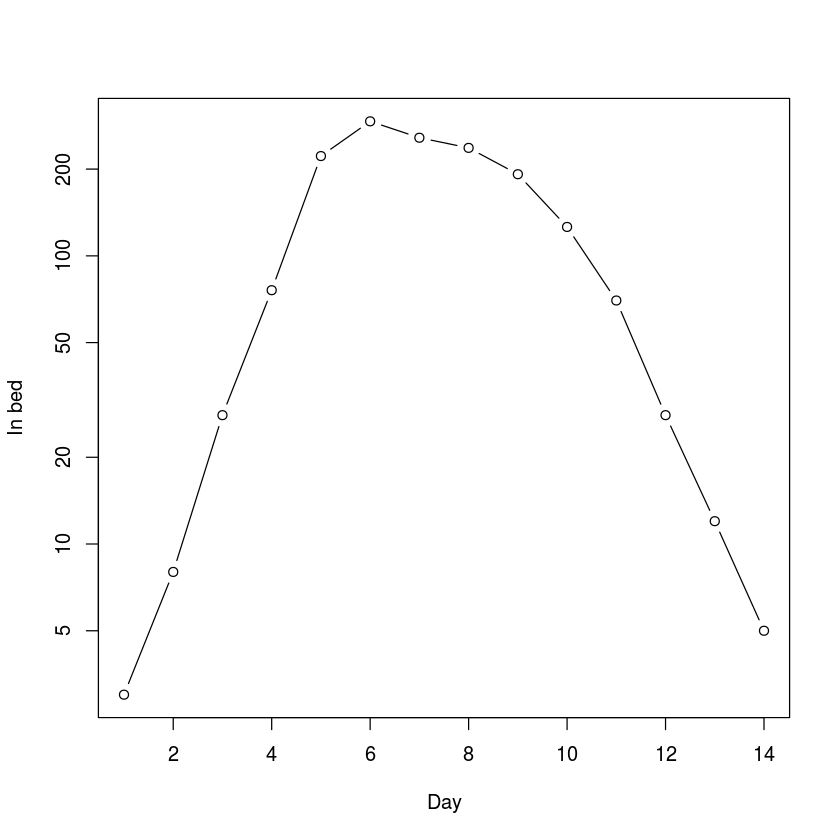

In [14]:
data(flu)
plot(flu$day, flu$cases, type="b", xlab="Day", 
     ylab="In bed", log="y")
tail(flu)

The “fast-and-furious" estimate of $R_0$ is thus:

In [15]:
fit=lm(log(cases)~day, subset=day<=5, 
     data=flu)
r=fit$coef["day"]
V=c(2,3)
V*r+1

[1] 3.171884 4.257827

This is higher than most estimates of $R_0$ of pandemic flu (which typically lies in the 1.5-2.5 interval). However, contact rates within a boarding school is likely to be higher than average across human populations as a whole.

### Ebola Sierra Leone 2014-15

The CDC’s record for the 2014-15 ebola outbreak in Sierra Leone is in the `ebola`-dataset. The serial interval for ebola is estimated at around 15 days with an incubation period of 11 days. The mean time to hospitalization is 5 days and mean time to death or dismissal was 5 and 11 days, respectively . The data is the back-calculated incidence as the difference of the cumulative cases reported by the [](http://www.cdc.gov/vhf/ebola/outbreaks/2014-west-africa/cumulative-cases-graphs.html). Because of the complexities of reporting and revisions of case-load through time, this lead to some negative numbers for certain dates. These were set to zero as a crude fix.

,date,day,cum_cases,cases
98,7/8/15,468,13945,34
99,7/15/15,475,13982,37
100,7/22/15,482,14001,19
101,7/29/15,489,14061,60
102,8/5/15,496,14089,28
103,8/12/15,503,14122,33


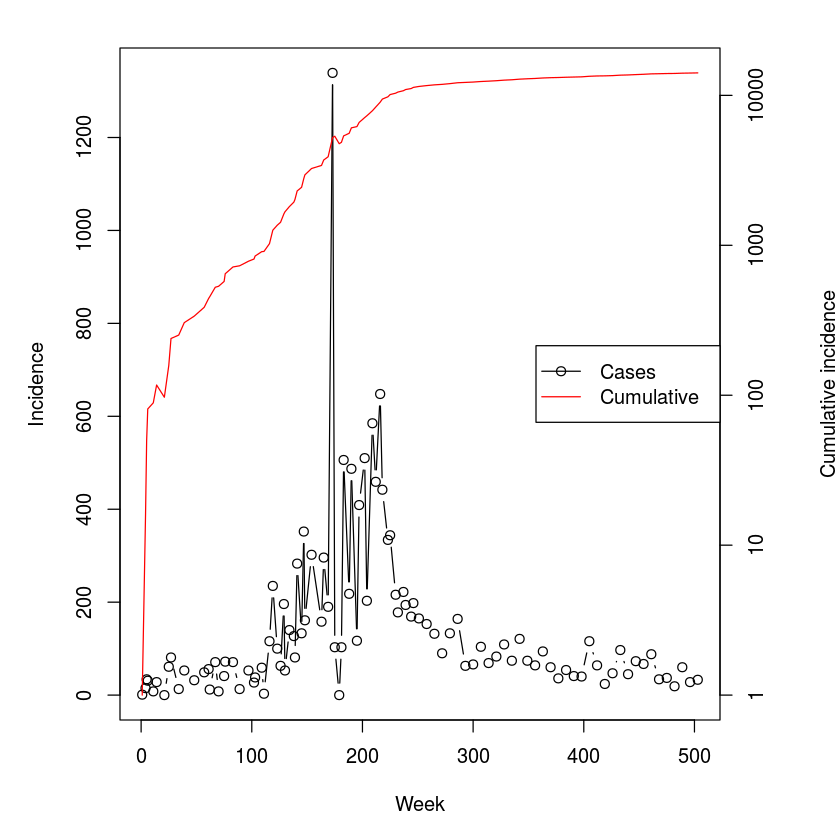

In [16]:
data(ebola)
par(mar = c(5,5,2,5))
plot(ebola$day, ebola$cases, type="b", xlab="Week", 
     ylab="Incidence")
par(new=T)
plot(ebola$day, ebola$cum_cases, type="l", col="red",
      axes=FALSE, xlab=NA, ylab=NA, log="y")
axis(side = 4)
mtext(side = 4, line = 4, "Cumulative incidence")
legend("right", legend=c("Cases", "Cumulative"),
     lty=c(1,1), pch=c(1,NA), col=c("black", "red"))
tail(ebola)

We first use the regression method with Lipsitch’s correction:

In [17]:
fit=lm(log(cum_cases)~day, subset=day<100, 
   data=ebola)
r=fit$coef["day"]
V=15
f=.5
V*r+1+f*(1-f)*(V*r)^2

day 
1.698811

We next aggregate the data in two-week increments roughly corresponding to the serial interval so we can apply the removal method.

In [18]:
#Data aggregation
cases=sapply(split(ebola$cases, 
   floor((ebola$day-.1)/14)), sum)
sum(cases)

#Removal MLE
fit = mle2(llik.cb, start = list(S0 = 20000, beta = 2), 
   method = "Nelder-Mead",data = list(I = cases))
summary(fit)

[1] 14721

Warning message in dbinom(I[-1], S, p, log = TRUE):
“NaNs produced”Warning message in dbinom(I[-1], S, p, log = TRUE):
“NaNs produced”Warning message in dbinom(I[-1], S, p, log = TRUE):
“NaNs produced”Warning message in dbinom(I[-1], S, p, log = TRUE):
“NaNs produced”Warning message in dbinom(I[-1], S, p, log = TRUE):
“NaNs produced”Warning message in dbinom(I[-1], S, p, log = TRUE):
“NaNs produced”Warning message in dbinom(I[-1], S, p, log = TRUE):
“NaNs produced”Warning message in dbinom(I[-1], S, p, log = TRUE):
“NaNs produced”Warning message in dbinom(I[-1], S, p, log = TRUE):
“NaNs produced”Warning message in dbinom(I[-1], S, p, log = TRUE):
“NaNs produced”

Maximum likelihood estimation

Call:
mle2(minuslogl = llik.cb, start = list(S0 = 20000, beta = 2), 
    method = "Nelder-Mead", data = list(I = cases))

Coefficients:
       Estimate Std. Error    z value     Pr(z)    
S0   2.7731e+04 2.5949e-07 1.0687e+11 < 2.2e-16 ***
beta 1.4237e+00 1.1783e-02 1.2083e+02 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

-2 log L: 5546.683 

Because of the difference in magnitude of the estimates of $S_0$ (in the ten thusands) and $R_0$ (around 1.4), the numerical method used to calculate confidence intervals struggles, so we suggest starting standard errors for the `confint`-function.

In [19]:
confint(fit, std.err = c(100, 0.1))

Warning message in optim(par = c(beta = 1.42370820032527), fn = function (p) :
“one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly”Warning message in optim(par = c(beta = 1.42370820032527), fn = function (p) :
“one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly”Warning message in optim(par = c(beta = 1.42370820032527), fn = function (p) :
“one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly”Warning message in optim(par = c(beta = 1.42370820032527), fn = function (p) :
“one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly”Warning message in optim(par = c(beta = 1.42370820032527), fn = function (p) :
“one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly”Warning message in optim(par = c(beta = 1.42370820032527), fn = function (p) :
“one-dimensional optimization by Nelder-Mead is unr

use "Brent" or optimize() directly”Warning message in optim(par = c(beta = 1.42370820032527), fn = function (p) :
“one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly”Warning message in optim(par = c(beta = 1.42370820032527), fn = function (p) :
“one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly”Warning message in optim(par = c(beta = 1.42370820032527), fn = function (p) :
“one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly”Warning message in optim(par = c(beta = 1.42370820032527), fn = function (p) :
“one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly”Warning message in optim(par = c(beta = 1.42370820032527), fn = function (p) :
“one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly”Warning message in optim(par = c(beta = 1.42370820032527), fn = function (p) :
“one-dimensional

,2.5 %,97.5 %
S0,26393.579452,29287.725327
beta,1.384683,1.463184


The removal and Lipsitch methods provides comparable estimates that are somewhat lower than those concluded by more elaborate analyses by the WHO team for the Sierra Leone outbreak .

### Ebola DRC 1995

| Disease     | Serial Interval | Location    | Year |
|:------------|:----------------|:------------|:----:|
| Ebola       | 14d             | DRC         | 1995 |
|             |                 | Uganda      | 2000 |
| SARS        | 5d              | Hong Kong   | 2003 |
|             |                 | Singapore   |      |
| Hog cholera | 7d              | Netherlands | 1997 |
| FMD         | 21d             | UK          | 2000 |

The `ferrari`-dataset holds the incidence data for a number of outbreaks – Ebola DRC ’95, Ebola Uganda ’00, SARS Hong Kong ’03, SARS Singapore ’03, Hog Cholera Netherlands ’97 and Foot-and-mouth UK ’00 – aggregated by disease-specific serial intervals . Let’s explore the 1995 DRC ebola outbreak.

In [20]:
names(ferrari)
ferrari$Ebolacases95
sum(ferrari$Ebolacases95, na.rm = TRUE)
y = c(na.omit(ferrari$Ebolacases95))

[1] "Eboladeaths00" "Ebolacases00"  "Ebolacases95"  "FMDfarms"     
[5] "HogCholera"    "SarsHk"        "SarsSing"

[1]  4  6  5 18 36 99 40 17  4  1 NA NA NA NA NA

[1] 230

The number of initial susceptibles must be larger than the summed incidence so we make an initial guess of 300.

In [21]:
fit = mle2(llik.cb, method = "Nelder-Mead", 
    start = list(S0 = 300, beta = 2), 
    data = list(I = y))
fit
confint(fit, std.err = 2)

Warning message in dbinom(I[-1], S, p, log = TRUE):
“NaNs produced”Warning message in dbinom(I[-1], S, p, log = TRUE):
“NaNs produced”Warning message in dbinom(I[-1], S, p, log = TRUE):
“NaNs produced”Warning message in dbinom(I[-1], S, p, log = TRUE):
“NaNs produced”Warning message in dbinom(I[-1], S, p, log = TRUE):
“NaNs produced”Warning message in dbinom(I[-1], S, p, log = TRUE):
“NaNs produced”Warning message in dbinom(I[-1], S, p, log = TRUE):
“NaNs produced”Warning message in dbinom(I[-1], S, p, log = TRUE):
“NaNs produced”Warning message in mle2(llik.cb, method = "Nelder-Mead", start = list(S0 = 300, :
“couldn't invert Hessian”


Call:
mle2(minuslogl = llik.cb, start = list(S0 = 300, beta = 2), method = "Nelder-Mead", 
    data = list(I = y))

Coefficients:
        S0       beta 
241.118108   3.181465 

Log-likelihood: -48.3 

Warning message in optim(par = c(beta = 3.18146475276021), fn = function (p) :
“one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly”Warning message in optim(par = c(beta = 3.18146475276021), fn = function (p) :
“one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly”Warning message in optim(par = c(beta = 3.18146475276021), fn = function (p) :
“one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly”Warning message in optim(par = c(beta = 3.18146475276021), fn = function (p) :
“one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly”Warning message in optim(par = c(beta = 3.18146475276021), fn = function (p) :
“one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly”Warning message in optim(par = c(beta = 3.18146475276021), fn = function (p) :
“one-dimensional optimization by Nelder-Mead is unr

,2.5 %,97.5 %
S0,233.973778,254.051292
beta,2.692505,3.718357


The estimated $R_0$ is 3.2. It thus appears that the Ebola outbreak in DRC in 1995 was more explosive than in Sierra Leone in 2014. This could be due to aggregation across a larger geographic area of the latter and/or the more intensive public health interventions. We will revisit on the DRC outbreak using the ‘next-generation matrix’ method.

### Contact tracing

The directional transmission graph of gonorrhoea among 89 individuals is in the `gonnet`-data set. The initial cluster of 17 cases all frequented the same bar, each infected between 0 and 7 other partners with 2.17 as the average. We can use the `statnet`-package to visualize the chains of transmission:

Loading required package: statnet
Loading required package: tergm
Loading required package: ergm
Loading required package: network
network: Classes for Relational Data
Version 1.13.0.1 created on 2015-08-31.
copyright (c) 2005, Carter T. Butts, University of California-Irvine
                    Mark S. Handcock, University of California -- Los Angeles
                    David R. Hunter, Penn State University
                    Martina Morris, University of Washington
                    Skye Bender-deMoll, University of Washington
 For citation information, type citation("network").
 Type help("network-package") to get started.


ergm: version 3.9.4, created on 2018-08-15
Copyright (c) 2018, Mark S. Handcock, University of California -- Los Angeles
                    David R. Hunter, Penn State University
                    Carter T. Butts, University of California -- Irvine
                    Steven M. Goodreau, University of Washington
                    Pavel N. Krivitsky, Un

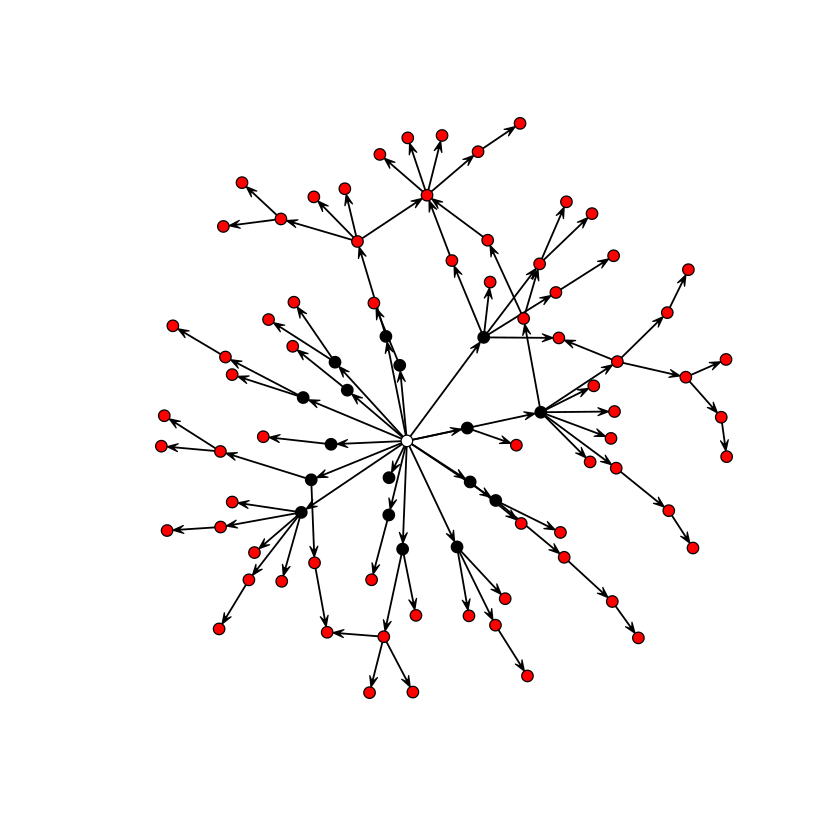

In [22]:
require(statnet)
data(gonnet)
nwt = network(gonnet, directed = TRUE)
plot(nwt, vertex.col = c(0, rep(1, 17), rep(2, 71)))

The subsequent infections, in turn, infected between 0 and 6 partners with an average of 0.62. The drop is (i) due to the sexual network being depleted of suscpetibles, and (ii) because infection across heterogenous networks will differentially infect individuals according to their number of contacts . Epidemics across social networks is the topic of chapter \[chap:c11\] and we will revisit on this network therein.

### Advanced: The next-generation matrix

For epidemics that are not simple linear chains, it is less straight-forward to calculate $R_0$ from parameterized models using the ‘logical method’. The [](https://en.wikipedia.org/wiki/Next-generation_matrix) is the general approach that work for all compartmental models of any complexity . It is done in a sequence of steps:

1.  Identify all $n$ infected compartments,

2.  Construct a $n \times 1$ matrix, $\vec{F}$, that contains expressions for all *completely new* infections entering each infected compartment,

3.  Construct a $n \times 1$ matrix, $\vec{V^-}$, that contains expressions for all losses out of each infected compartment,

4.  Construct a $n \times 1$ matrix, $\vec{V^+}$, that contains expressions for all gains into each infected compartment that does *not* represent *new* infections but transfers among infectious classes,

5.  Construct a $n \times 1$ matrix, $\vec{V}= \vec{V^-} - \vec{V^+}$,

6.  Generate two $n \times n$ Jaccobian matrices, $\vec{f}$ and $\vec{v}$ that are the partial derivatives of $\vec{F}$ and $\vec{V}$ with respect to the $n$ infectious state variables,

7.  Evaluate the matrices at the disease free equilibrium (dfe) finally

8.  $R_0$ is the greatest eigenvalue of $\vec{f} \vec{v}^{-1}|_{dfe}$.

#### SEIR

This is quite an elaborate scheme, so we will try it out first for the SEIR model for which we already know the answer. Unfortunately, `R` can not do vectorized *symbolic* calculations, so we need to do this, one matrix element at a time. In chapter 1, we discussed how to use `expression` to do symbolic calculations in `R`. The `quote`-function is an alternative way to define mathematical expressions; `substitute` allows some simple additional manipulations.

Step 1: Infected classes are $E$ and $I$, let us label them 1 and 2.

Step 2: All new infections: $dE/dt = \beta S I / N$, $dI/dt =0$

In [23]:
F1 = quote(beta * S * I/N)
F2 = 0

Step 3: All losses $dE/dt= (\mu+\sigma) E$, $dI/dt=(\mu + \alpha + \gamma) I$

In [24]:
Vm1 = quote(mu * E + sigma * E)
Vm2 = quote(mu * I + alpha * I + gamma * I)

Step 4 : All gained transfers $dE/dt= 0$, $dI/dt=(\sigma) E$

In [25]:
Vp1 = 0
Vp2 = quote(sigma * E)

Step 5: Subtract Vp from Vm

In [26]:
V1 = substitute(a - b, list(a = Vm1, b = Vp1))
V2 = substitute(a - b, list(a = Vm2, b = Vp2))

Step 6: Generate the partial derivatives for the two Jacobians

In [27]:
f11 = D(F1, "E"); f12 = D(F1, "I")
f21 = D(F2, "E"); f22 = D(F2, "I")

v11 = D(V1, "E"); v12 = D(V1, "I")
v21 = D(V2, "E"); v22 = D(V2, "I")

Step 7: Assuming N=1, the disease free equilibrium (dfe) is $S=1, E=0, I=0, R=0$. We also need values for other parameters. Assuming a weekly time-step and something chickenpox-like we may use $\mu=0$, $\alpha=0$, $\beta=5$, $\gamma=.8$, $\sigma=1.2$, and $N=1$.

In [28]:
paras = list(S = 1, E = 0, I = 0, R = 0, mu = 0, 
   alpha = 0, beta = 5, gamma = .8, sigma = 1.2, N = 1)
f = with(paras,
   matrix(c(eval(f11),eval(f12),eval(f21),
   eval(f22)), nrow = 2, byrow = TRUE))
v=with(paras,
   matrix(c(eval(v11),eval(v12),eval(v21),
   eval(v22)), nrow=2, byrow=TRUE))

Step 8: Calculate the largest eigenvalue of $f \times \mbox{inverse}(v)$. Note that the function for inverting matrices in `R` is `solve`.

In [29]:
max(eigen(f %*% solve(v))$values)

[1] 6.25

Let us check that the next-generation method and the ‘flow’ method are in agreement recalling that for the SEIR-flow $R_0 =  \frac{\sigma}{\sigma +\mu} \frac{\beta}{\gamma+\mu+\alpha}$.

In [30]:
with(paras,
sigma/(sigma+mu)*beta/(gamma+mu+alpha))

[1] 6.25

#### SEIHFR

| Parameter    | Meaning                        |  Value|
|:-------------|:-------------------------------|------:|
| $N$          | Population size                |       |
| $1/\sigma$   | Incubation period              |     7d|
| $1/\gamma_h$ | Onset to hospitalization       |     5d|
| $1/\gamma_f$ | Onset to death                 |   9.6d|
| $1/\gamma_r$ | Onset to recovery              |    10d|
| $1/\eta_f$   | Hospitalization to death       |   4.6d|
| $1/\eta_r$   | Hospitalization to recovery    |     5d|
| $1/\chi$     | Death to burial                |     2d|
| $\Theta$     | Proportion hospitalized        |    80%|
| $\Lambda$    | Case fatality ratio            |    81%|
| $\beta_i$    | Transmission rate in community |  0.588|
| $\beta_h$    | Transmission rate in hospital  |  0.794|
| $\beta_f$    | Transmission rate at funeral   |  7.653|

The SEIHFR model forms the foundation for many of the recent Ebola models. The model has 5 compartments corresponding to Susceptible, Exposed, Infectious in community, Infectious in hospital, Dead but not yet buried, and removed (either buried or immune). The model is more complex than previous compartmental models and can not be represented by a simple linear chain. The parameterization used here is motivated by the original formulation of , but the notation conforms to the other sections of this book; Each infectious compartment contributes to the force of infection through their individual $\beta$s. There are two branching-points in the flow: The hospitalization of a fraction $\Theta$ of the infectious cases after an average time of $1/\gamma_h$ days following onset of symptoms, and the death of a fraction $\Lambda$ of the $I$- and $H$-class after an average time of $1/\gamma_f$ days and $1/\eta_f$ days, respectively. For the 1995 DRC outbreak, assumed that hospitalization affected transmission rates but not duration of infection or probability of dying. Model parameters are given above, and the model equations are:

$$\begin{aligned}
\frac{dS}{dt}&=&-(\beta_i I + \beta_h H +\beta_f F) S / N\\
\frac{dE}{dt}&=& (\beta_i I + \beta_h H +\beta_f F) S / N - \sigma E\\
\frac{dI}{dt}&=&\sigma E - \Theta \gamma_h I -(1-\Theta)(1-\Lambda)\gamma_r I - (1-\Theta) \Lambda \gamma_f I\\
\frac{dH}{dt}&=&\Theta \gamma_h I - \Lambda \eta_f H - (1-\Lambda) \eta_r H\\
\frac{dF}{dt}&=& (1-\Theta)(1-\Lambda)\gamma_r I+ \Lambda \eta_f H - \chi F\\
\frac{dR}{dt}&=&(1-\Theta)(1-\Lambda)\gamma_r I + (1-\Lambda) \eta_r H+\chi F
\end{aligned}$$

There are 4 infected compartments ($E$, $I$, $H$ and $F$), thus $\vec{F}$, $\vec{V^-}$, and $\vec{V^+}$ will be $4 \times 1$ matrices, and $\vec{f}$ and $\vec{v}$ will be $4 \times 4$ matrices.

Step 1: Infected classes are $E$, $I$, $H$ and $F$, let us label them F1 - 4.

Step 2: All new infections $dE/dt = \beta S I / N$, $dI/dt =0$

In [31]:
F1 = expression(betai * S * I / N + betah* S * H / N +
   betaf * S * F / N)
F2=0
F3=0
F4=0

Step 3: All losses

In [32]:
Vm1 = quote(sigma * E)
Vm2 = quote(Theta * gammah * I + (1 - Theta) * (1-
   Lambda) * gammar * I + (1 - Theta) * Lambda * 
   gammaf * I)
Vm3 = quote(Lambda * etaf * H + (1 - Lambda) * etar * H)
Vm4 = quote(chi * F)

Step 4: All gained transfers

In [33]:
Vp1 = 0
Vp2 = quote(sigma * E)
Vp3 = quote(Theta * gammah * I)
Vp4 = quote((1 - Theta) * (1 - Lambda) * gammar * I+ 
   Lambda * etaf * H)

Step 5: Subtract Vp from Vm

In [34]:
V1 = substitute(a - b, list(a = Vm1, b = Vp1))
V2 = substitute(a - b, list(a = Vm2, b = Vp2))
V3 = substitute(a - b, list(a = Vm3, b = Vp3))
V4 = substitute(a - b, list(a = Vm4, b = Vp4))

Step 6: Generate the partial derivatives for the two Jacobians

In [35]:
f11 = D(F1, "E"); f12 = D(F1, "I"); f13 = D(F1, "H") 
     f14 = D(F1, "F")
f21 = D(F2, "E"); f22 = D(F2, "I"); f23 = D(F2, "H") 
     f24 = D(F2, "F")
f31 = D(F3, "E"); f32 = D(F3, "I"); f33 = D(F3, "H") 
     f34 = D(F3, "F")
f41 = D(F4, "E"); f42 = D(F4, "I"); f43 = D(F4, "H") 
     f44 = D(F4, "F")

v11 = D(V1, "E"); v12 = D(V1, "I"); v13 = D(V1, "H")
     v14 = D(V1, "F")
v21 = D(V2, "E"); v22 = D(V2, "I"); v23 = D(V2, "H")
     v24 = D(V2, "F")
v31 = D(V3, "E"); v32 = D(V3, "I"); v33 = D(V3, "H")
     v34 = D(V3, "F")
v41 = D(V4, "E"); v42 = D(V4, "I"); v43 = D(V4, "H")
     v44 = D(V4, "F")

Step 7: Disease free equilibrium: the dfe is $S=1, E=0, I=0, H=0, F=0, R=0$. We also need values for other parameters. We use the estimates from the DRC 1995 outbreak scaled as weekly rates from tables and appendices of .

In [36]:
gammah = 1/5 * 7
gammaf = 1/9.6 * 7
gammar = 1/10 * 7
chi = 1/2 * 7
etaf = 1/4.6 * 7
etar = 1/5 * 7
paras = list(S = 1,E = 0, I = 0, H = 0, F = 0,R = 0,
     sigma = 1/7*7, Theta = 0.81, Lambda = 0.81, betai = 0.588, 
     betah = 0.794, betaf = 7.653, N = 1, gammah = gammah,
     gammaf = gammaf, gammar = gammar, etaf = etaf, 
     etar = etar, chi = chi)

f = with(paras, 
matrix(c(eval(f11), eval(f12), eval(f13), eval(f14),
     eval(f21), eval(f22), eval(f23), eval(f24),
     eval(f31), eval(f32), eval(f33), eval(f34),
     eval(f41), eval(f42), eval(f43), eval(f44)),
     nrow = 4, byrow = T))

v = with(paras, 
matrix(c(eval(v11), eval(v12), eval(v13), eval(v14),
     eval(v21), eval(v22), eval(v23), eval(v24),
     eval(v31), eval(v32), eval(v33), eval(v34),
     eval(v41), eval(v42), eval(v43), eval(v44)),
     nrow = 4, byrow = T))

Step 8: Calculate the largest eigenvalue of $f \times \mbox{inverse}(v)$

In [37]:
max(eigen(f %*% solve(v))$values)

[1] 2.582429